# Dask

**Dask** is a flexible parallel computing library for analytics. Dask emphasizes the following virtues:

- _Familiar_: Provides parallelized NumPy array and Pandas DataFrame objects
- _Native_: Enables distributed computing in Pure Python with access to the PyData stack
- _Fast_: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
- _Flexible_: Supports complex and messy workloads
- _Scales up_: Runs resiliently on clusters up to hundreds of nodes
- _Scales down_: Trivial to set up and run on a laptop in a single process
- _Responsive_: Designed with interactive computing in mind it provides rapid feedback and diagnostics to aid humans

## The Dask Computational Model

* Parallel programming with task scheduling
* Familiar abstractions for executing tasks in parallel on data that doesn't fit into memory
    * Arrays, DataFrames
* Task graphs
    * Representation of a parallel computation
* Scheduling
    * Executes task graphs in parallel on a single machine using threads or processes
    * Preliminary support for parallel execution using `dask.distributed`
    
## Dask Array

Enabled within dask arrays are:

* Arithmetic and scalar mathematics: $+, *, \exp, \log, \dots$
* Reductions along axes: `sum()`, `mean()`, `std()`
* Tensor contractions / dot products / matrix multiply
* Axis reordering / `transpose`
* Slicing, `x[:100, 100:500:-1]`
* Fancy indexing along single axes with lists or numpy arrays
* Linear algebra `svd`, `qr`, `solve`, `lstsq`

In [1]:
import dask.array as da

Dask operates on a **delayed computational model**. It builds up an expression of the computation in chunks, by creating a **Task Graph** that you can explore.

In [2]:
x = da.arange(25, chunks=5)
x

dask.array<arange, shape=(25,), dtype=int64, chunksize=(5,)>

In [3]:
y = x**2
y

dask.array<pow, shape=(25,), dtype=int64, chunksize=(5,)>

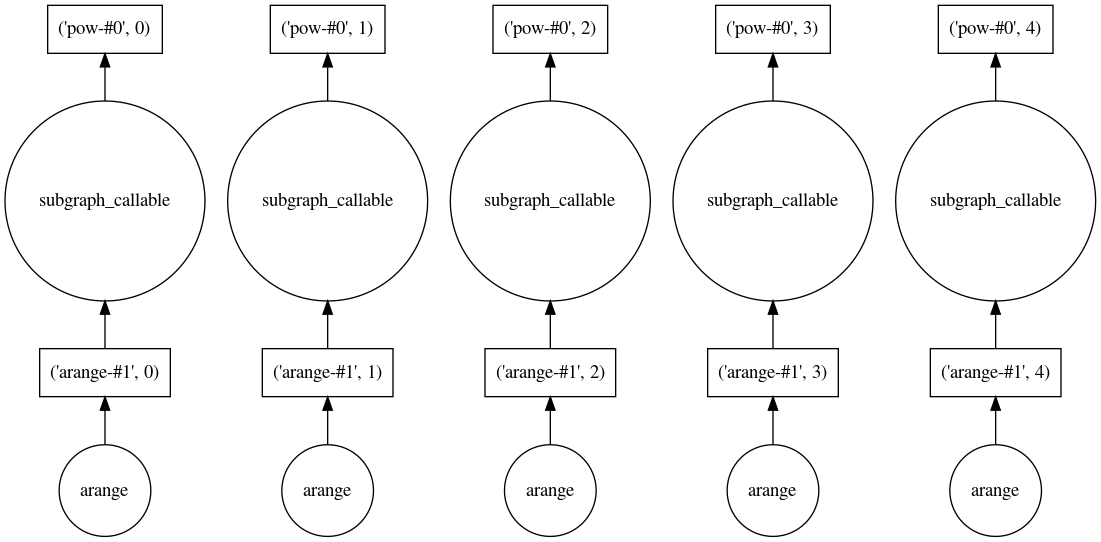

In [4]:
y.visualize()

In [5]:
y.dask.keys()

KeysView(<dask.sharedict.ShareDict object at 0x7f4af0ca5be0>)

In [6]:
y.compute()

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

## Scheduling Backends

You can control the scheduler backend that is used by `compute`.

These choices can be important in a few situations:
* Debugging
* Fast tasks
* Cross-task communication

*single-threaded* scheduling is the most basic:

In [7]:
import dask
y.compute(scheduler="single-threaded")

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

In [8]:
y.compute(scheduler="synchronous")

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

### Process Scheduler

* Backend that uses multiprocessing
* Uses a process pool backend
    * On unix-like system this is a system call to fork
    * Calling fork creates a new child process which is a copy(-on-write) of the parent process
    * Owns its own resources. This is "heavy"
* Limitations
    * Relies on serializing objects for the workers (slow and error prone)
    * Workers must communicate through parent process



In [9]:
y.compute(scheduler="multiprocessing")

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

## Blocked Algorithms



* Dask works on arrays by executing blocked algorithms on chunks of data
* For example, consider taking the mean of a billion numbers. We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums and divide this by the total number of observations.
* the result (one sum on one billion numbers) is performed by many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)



In [10]:
x = da.random.random((10000,10000), chunks=(1000,1000))
result = x.mean()
result

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>

In [11]:
result.compute()

0.5000055979216672

In [12]:
y = da.random.normal(10, 0.1, size=(20000,20000), chunks=(1000,1000))
z = y[::100].mean(axis=0)
z.compute()

array([ 9.99878654,  9.98968803,  9.99788078, ...,  9.99987156,
        9.99876636, 10.00430624])

## Performance vs. NumPy

Your performance may vary. If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

In [13]:
import numpy as np

In [14]:
%%time
x = np.random.normal(10., .1, size=(20000,20000))
y = x.mean(axis=0)[::100]
y

CPU times: user 17 s, sys: 645 ms, total: 17.6 s
Wall time: 17.6 s


In [15]:
%%time
x = da.random.normal(10., .1, size=(20000,20000), chunks=(1000,1000))
y = x.mean(axis=0)[::100]
y.compute()

CPU times: user 20.3 s, sys: 359 ms, total: 20.6 s
Wall time: 2.82 s


## Tasks

**Conway's Game of Life** is a cellular automaton devised by British mathematician Jon Conway. 

The game is a zero-player game, relying on it's initial state and requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

The universe of the *Game of Life* is an infinite, two-dimensional orthogonal grid of *square cells*, each of which is in one of two possible states: **alive** or **dead**. Every cell interacts with it's eight neighbours, which are the cells horizontally, vertically or diagonally adjacent. For each step in time, the following transitions can occur:

1. Any live cell with fewer than 2 live neighbours dies, as if by underpopulation
2. Any live cell with two or three live neighbours lives on to the next generation
3. Any live cell with more than three live neighbours dies, as if my overpopulation
4. Any dead cell with exactly three live neighbours becomes a live cell, as if my reproduction

For edge cases, we include periodic boundary conditions:

$$
X_{-1,j}=X_{m-1,j} \\
X_{m,j}=X_{0,j} \\
X_{i,-1}=X_{i,n-1} \\
X_{i,n}=X_{i,0} \\
$$

where $X$ represents the 2-D board of life.

### Task 1

Implement **Conway's Game of Life** using Dask. We highly recommend you make use of `da.map_overlap` to access neighbouring zones between blocks of the array. Begin with $N=10$.

In [16]:
def life_step_dask(x):
    
    def access_roll(x):
        #da.roll extracts an array where all values are shifted left, right, up or down
        l_roll = da.roll(x,1,axis=0)
        r_roll = da.roll(x,-1,axis=0)
        return l_roll + r_roll + da.roll(x,1,axis=1) + da.roll(x,-1,axis=1) + \
            da.roll(l_roll, 1, axis=1) + da.roll(l_roll, -1, axis=1) + \
            da.roll(r_roll, 1, axis=1) + da.roll(r_roll, -1, axis=1)
    
    c_grid = da.map_overlap(x, access_roll, depth=1, boundary="periodic")
    
    nx = x - ((x == 1) & ((c_grid < 2) | (c_grid > 3))).astype(np.int)
    nx = nx + ((x == 0) & (c_grid == 3)).astype(np.int)
    return nx

N=10
x = da.random.randint(2, size=(N,N), chunks=(5,5))
y = life_step_dask(x).compute()
print(np.array(x))
print(y)

[[0 0 1 0 1 1 0 1 1 1]
 [0 1 1 0 1 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 1 1]
 [0 1 0 0 1 1 1 1 0 0]
 [0 1 1 0 1 0 0 1 0 0]
 [1 1 1 1 1 0 0 1 0 0]
 [0 0 1 0 0 1 1 1 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 1 1 0 1 1 1 1 1 1]
 [1 1 0 1 0 1 1 1 1 0]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 1 1 1 0 0 0 1 1 1]
 [1 1 1 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]


### Task 2

Repeat Task 1, except set $N=10^4$, with an appropriate chunksize (i.e $C=10^3$). Does it run in a reasonable amount of time?

In [17]:
N=10000
chunksize = 1000
x = da.random.randint(2, size=(N,N), chunks=(chunksize,chunksize))
y = life_step_dask(x).compute()
print(np.array(x))
print(y)

[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [0 1 1 ... 0 1 0]
 ...
 [1 0 0 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 1 1 0]]
[[0 1 0 ... 0 1 0]
 [1 1 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


### Task 3

Plot 16 steps of Conway's Game of Life in 16 matplotlib plots (arranged as you like), using $N=100$. Remember that `.compute()` returns a `numpy.array`, so you will need to re-create the Dask array.

In [18]:
from dask import delayed
import matplotlib.pyplot as plt
%matplotlib inline

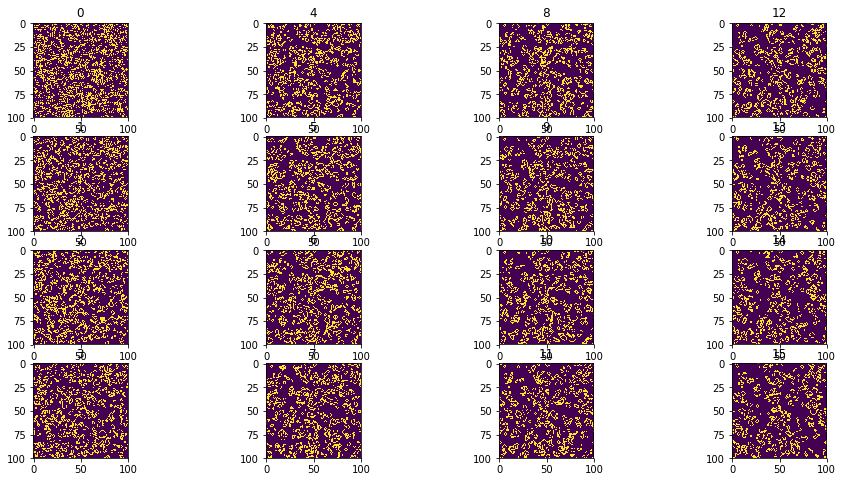

In [19]:
N=100
chunksize = 50
steps = 16

x = da.random.randint(2, size=(N,N), chunks=(chunksize,chunksize))

fig,ax=plt.subplots(ncols=4, nrows=4, figsize=(16,8))

current = x
for i in range(steps):
    curr_arr = life_step_dask(current).compute()
    # re-create dask array from numpy.array
    current = da.from_array(curr_arr, chunks=(chunksize,chunksize))
    # plot
    ax[i%4,int(i/4)].imshow(curr_arr)
    ax[i%4,int(i/4)].set_title(i)

### Task 4

Now run with $N=1000$, for 200 steps, and plot step $t$ against the mean number of alive automata at each step.

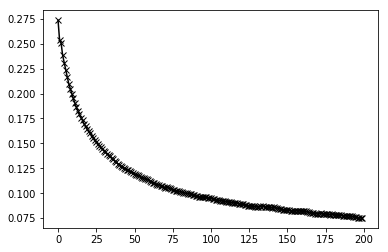

In [59]:
N=1000
chunksize = 500
steps = 200

x = da.random.randint(2, size=(N,N), chunks=(chunksize,chunksize))
t = np.arange(steps)
s_tot = np.zeros(steps)

fig,ax=plt.subplots()

current = x
for i in range(steps):
    curr_arr = life_step_dask(current).compute()
    # compute sum
    s_tot[i] = curr_arr.mean()
    # re-create dask array from numpy.array
    current = da.from_array(curr_arr, chunks=(chunksize,chunksize))

ax.plot(t, s_tot, 'kx-')